In [ ]:
import math
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
#@title round-robin-like algorithm
def round_robin(seed, T):
    r"""
    Round-Robin strategy
    :param seed: Seeding the RNG
    :param T: Budget of the algorithm
    :return: [bool] indicates whether the true Pareto set has been identified
    """
    np.random.seed(seed)
    num_pulls = int(np.floor(T/K))
    total = np.zeros((K, D))
    Nc = np.zeros(K, dtype=int)
    for a in arms:
        total[a] += bandit.sample([a] * num_pulls).sum(0)
        Nc[a] += num_pulls
    remains = T - num_pulls*K
    for _ in range(remains):
        a = np.random.randint(K)
        total[a] += bandit.sample(a).reshape(-1)
        Nc[a] += 1
    St_star_mask = is_non_dominated(total/Nc[:, None])
    St_star = arms[St_star_mask]
    return set(list(St_star))==set(S_star)

[pareto set]:  {2, 5, 7} 
[complexity H] = 353.83898684981915


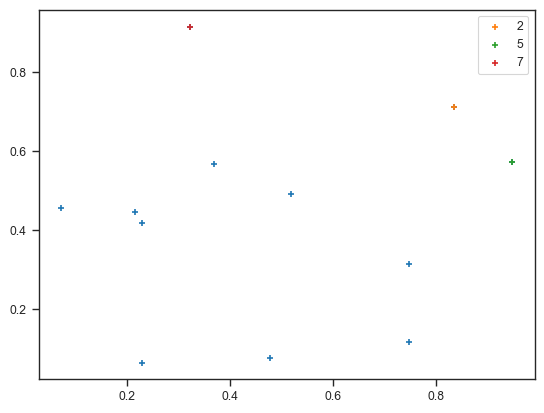

In [29]:
#@title Define a bandit instance
K = 12
D = 2
inf = (1<<31)*1. 
arms = np.arange(K)
while True:
    try:
        arms_means = np.random.uniform(0, 1, size=(K, D))
        S_star_mask = is_non_dominated(arms_means)
        S_star = set(S_star_mask.nonzero()[0])
        S_star_comp = set((~S_star_mask).nonzero()[0])
        Deltas = np.array([Delta_i(i, S_star, S_star_comp, arms_means) for i in range(K)]) 
        H = sum(1/Deltas**2)
        if (H<1000): break # any condition
    except Exception as e:
        print(e, S_star)
      #break 
      #continue
bandit = BernoulliBandit(arms_means=arms_means)
print("[pareto set]: ", S_star, "\n[complexity H] =", H)
if D==2:
    plt.scatter(*arms_means.T, marker="+")
    for k in S_star: plt.scatter(*arms_means[k], label="%d"%k, marker="+"); plt.legend()

#### EGE-SR

In [30]:
def ege_sr(seed, T):
    r"""
    Implements EGE SR
    :param seed: Seeding the RNG
    :param T: Budget of the algorithm
    :return: [bool] indicates identification of the true Pareto set
    """
    np.random.seed(seed)
    # implementing the SR scheme [cf Audibert et al 2010]
    log_K = 1/2 + np.sum(1 / np.arange(2, K + 1))
    n_ks = np.ceil([0, *(1 / log_K) * (T - K) / (K + 1 - np.arange(1, K))]).astype(int)
    total = np.zeros((K, D))
    active = np.ones(K, bool)
    means = np.empty((K,D), float)
    Nc = np.zeros(K, dtype=int)
    accepts  = []
    rejects = []
    for r in range(1, K):
        num_pulls = n_ks[r] - n_ks[r - 1]
        if num_pulls > 0:
            for a in arms[active]:
                total[a] += bandit.sample([a] * num_pulls).sum(0)
                Nc[a] += num_pulls
            means[active] = total[active] / Nc[active, None]
        active_idx = arms[active]
        Ik = np.eye(active.sum())
        index_of = {v:k for k,v in enumerate(active_idx)}
        g_i = lambda i : max(m(means[i], means[active]) - inf * Ik[index_of[i]])
        f_i = lambda i :  min(min(M(means[i], means[active]) + inf * Ik[index_of[i]]), min([max(M(means[j], means[i]), 0) + max(g_i(j),0)  for j in active_idx] + inf * Ik[index_of[i]]))
        rk, dk, ak = [None]*3
        indices = [-np.inf, -np.inf]
        dk = active_idx[np.argmax([g_i(i) for i in active_idx])]
        indices[0] = g_i(dk)
        ak = active_idx[np.argmax([f_i(i) for i in active_idx])]
        indices[1] = f_i(ak)
        # Implements the tie-breaking rule
        if indices[0] >= indices[1]:
            # remove an arm and classify as sub-optimal
            rejects +=[dk]
            rk = dk
        else:
            #accept an arm as optimal
            accepts +=[ak]
            rk = ak
        active[rk] = False
    accepts +=  [*arms[active]]
    return set(accepts)==set(S_star)

#### EGE-SH

In [31]:
def ege_sh(seed, T):
    r"""
    Implements EGE-SH
    :param seed: Seeding the RNG
    :param T: Budget of the algorithm
    :return: [bool] indicates identification of the true Pareto set
    """
    np.random.seed(seed)
    # defines a small constant to implement the tie Breaking rule
    # the gaps of empirically sub-optimal arms are increased by c_0
    c_0 = 1e-7
    total = np.zeros((K, D))
    active = np.ones(K, bool)
    means = np.empty((K,D), float)
    Nc = np.zeros(K, dtype=int)
    accepts  = []
    rejects = []
    # implementing the SH scheme
    ceil_log2_K = math.ceil(np.log2(K))
    for k in range(ceil_log2_K):
        num_pulls = math.floor(T / (sum(active) * ceil_log2_K))
        if num_pulls > 0:
            for a in arms[active]:
                total[a] += bandit.sample([a] * num_pulls).sum(0)
                Nc[a] += num_pulls
            means[active] = total[active] / Nc[active, None]
        active_idx = arms[active]
        Sk_star_mask = is_non_dominated(means[active_idx])
        Sk_star = active_idx[Sk_star_mask]
        Sk_star_comp = active_idx[~Sk_star_mask]
        Ik = np.eye(active.sum())
        index_of = {v:k for k,v in enumerate(active_idx)}
        g_i = lambda i : max(m(means[i], means[active]) - inf * Ik[index_of[i]])
        f_i = lambda i :  min(min(M(means[i], means[active]) + inf * Ik[index_of[i]]), min([max(M(means[j], means[i]), 0) + max(g_i(j),0)  for j in active_idx ] + inf * Ik[index_of[i]]))
        # compute empirical gaps
        Delta_i = lambda i: f_i(i) if (Sk_star_mask[index_of[i]]) else (c_0+g_i(i))
        num_arms_to_keep = math.ceil(len(active_idx) / 2)
        # sort arms by their gaps
        sorted_arms = np.argsort([-Delta_i(i) for i in active_idx])
        arms_to_dismiss = active_idx[sorted_arms[:-num_arms_to_keep]]
        # classify the dismissed arms
        for a in arms_to_dismiss:
            active[a] = False 
            if Sk_star_mask[index_of[a]]:
                accepts += [a]
            else:
                rejects +=[a]
    assert sum(active)==1, "There should not be more than one active arm remaining"
    accepts += [*arms[active]]
    return set(accepts)==set(S_star)

#### Numerical Experiment

In [34]:
numrep = 500 # number of trials
numtps = 10 # number of budgets
T_max = 500 # max budget
seeds = (np.random.uniform(size=numrep)*2**31).astype(int) # generate random seeds
T_range = np.linspace(max(K, 100), T_max, numtps).astype(int) # generate budget ranges
sns.set_style("ticks")
sns.set_context("paper")
sns.color_palette("viridis");

In [33]:
res_ege_sr = np.array([run_batch_seeds(T, seeds, ege_sr) for T in T_range])
res_ege_sh = np.array([run_batch_seeds(T, seeds, ege_sh) for T in T_range])
res_robin =  np.array([run_batch_seeds(T, seeds, round_robin) for T in T_range])

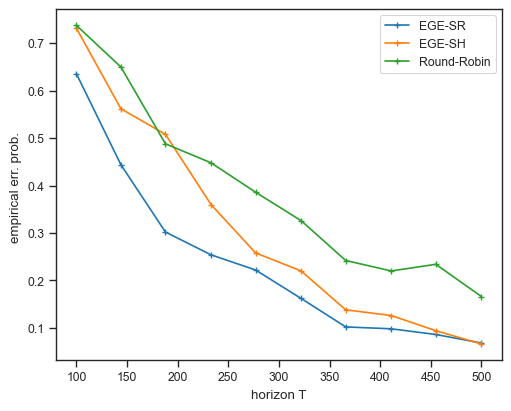

In [35]:
f = plt.figure(figsize=(5, 4), layout='constrained')
plt.plot(T_range, 1-res_ege_sr, label="EGE-SR", marker="+")
plt.plot(T_range, 1-res_ege_sh, label="EGE-SH", marker="+")
plt.plot(T_range, 1-res_robin, label="Round-Robin", marker="+")
plt.xlabel("horizon T")
plt.ylabel(r"empirical err. prob. ")
plt.legend()